In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
# path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
path = '/Users/dhortadarrington/Documents/Master/data/mwmAllStar-apogee-gaiadr3-joined-MilkyWayPotential2022-agama.fits'
tb = fits.open(path)
data = tb[1].data 
print(len(data))

1099648


In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [4]:
apo_id = data['sdss_id']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

KeyError: "Key 'STARFLAG' does not exist."

In [6]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>0.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')

KeyError: "Key 'SNR' does not exist."

In [7]:
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError

A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [8]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-8.4,31.8,8.4]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz


In [9]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data)

In [10]:
# Eilers rotation curve
R = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(R-8.275)
Rg = (-data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/-data['xyz'][:,0])
phi_x1 = R*np.cos(phi)
phi_y1 = R*np.sin(phi)
vr = vRvTvz[:,0]*220.
print(R)
deltaR = R-Rg


[ 9.87188323  8.63580707 22.58525074 ...  5.15168728  5.15372958
  5.80486113]


In [11]:
line = data['FE_H']*-0.167 + 0.12

lowa = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))

higha = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))
# ((data['FE_H']>-1)&(data['FE_H']<0.)&(data['MG_FE']>line))|((data['FE_H']>0.)&(data['FE_H']<0.6)&(data['MG_FE']>0.12))

print(len(data[mask&lowa]))
print(len(data[mask&higha]))


121413
42244


# Using the high-/low-$\alpha$ samples, plot the metallicity and $\alpha/Fe$ maps of stars in $R_g-z_{\mathrm{max}}$, E-L$_{z}$, and L$_{\perp}$-L$_{z}$

In [12]:
zmax = data['z_max']
E = data['E']
lz = -data['L'][:,2]
lperp = np.sqrt(data['L'][:,0]**2+data['L'][:,1]**2)

In [15]:
zmax

array([ 0.54208285,  0.04255325, 17.9727498 , ...,  2.97091248,
        2.84444616,  0.65405666])

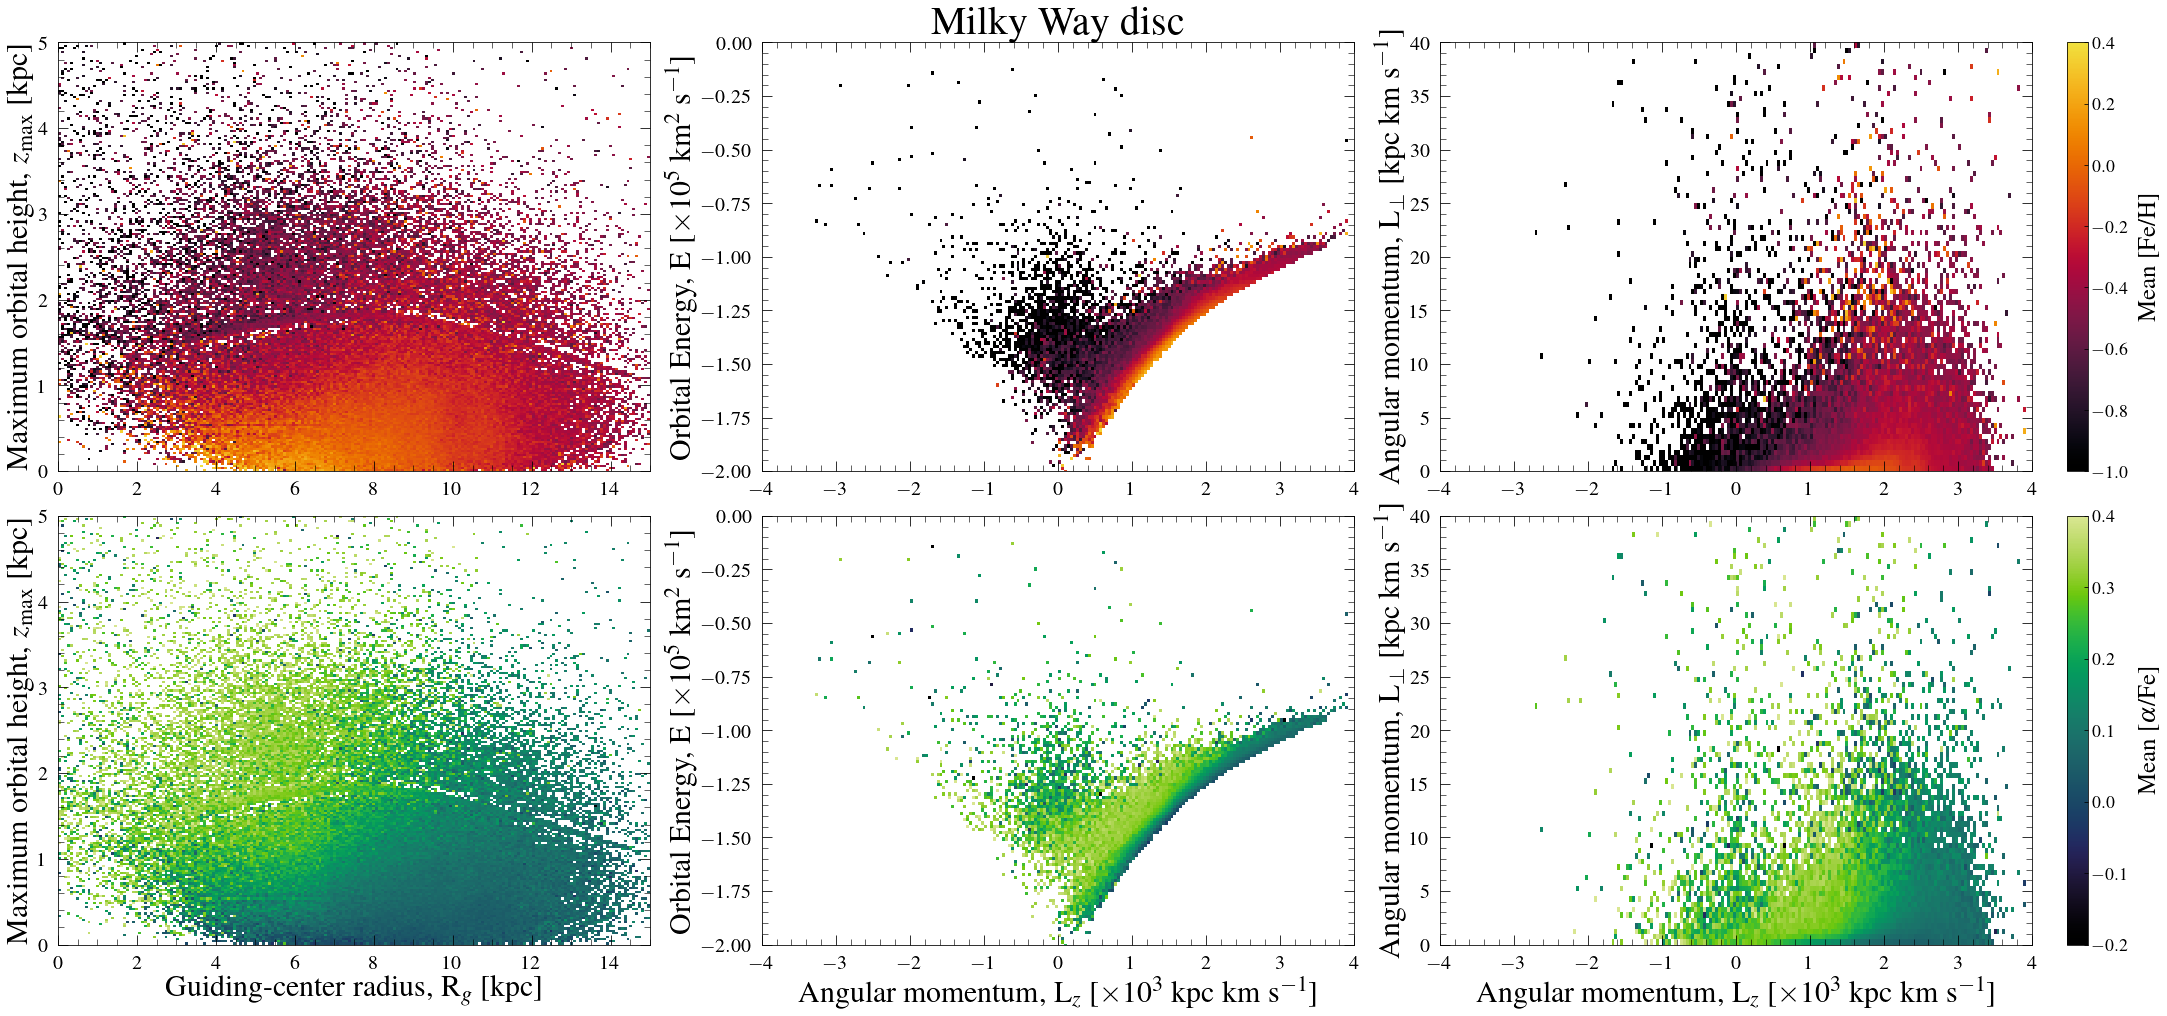

In [48]:
nbins=201
fig = plt.figure(figsize=(30,14),facecolor='white',constrained_layout=True,rasterized=True)

# fig.suptitle(r'Element abundance gradients of the Milky Way disc in orbit space', fontsize=50, y = 1.1)

plt.subplot(2,3,1)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot],zmax[mask&mask_plot], data['FE_H'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,2)
plt.title(r'Milky Way disc', fontsize=40)

mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot]/1e3,E[mask&mask_plot]/1e5, data['FE_H'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot]/1e3,lperp[mask&mask_plot], data['FE_H'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [Fe/H]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')




plt.subplot(2,3,4)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot],zmax[mask&mask_plot], data['MG_FE'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
plt.xlabel(r'Guiding-center radius, R$_{g}$ [kpc]',fontsize=30)
plt.ylabel(r'Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,5)
mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot]/1e3,E[mask&mask_plot]/1e5, data['MG_FE'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot]/1e3,lperp[mask&mask_plot], data['MG_FE'][mask&mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [$\alpha$/Fe]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-abundance-maps-all.pdf',dpi=200, bbox_inches = 'tight')



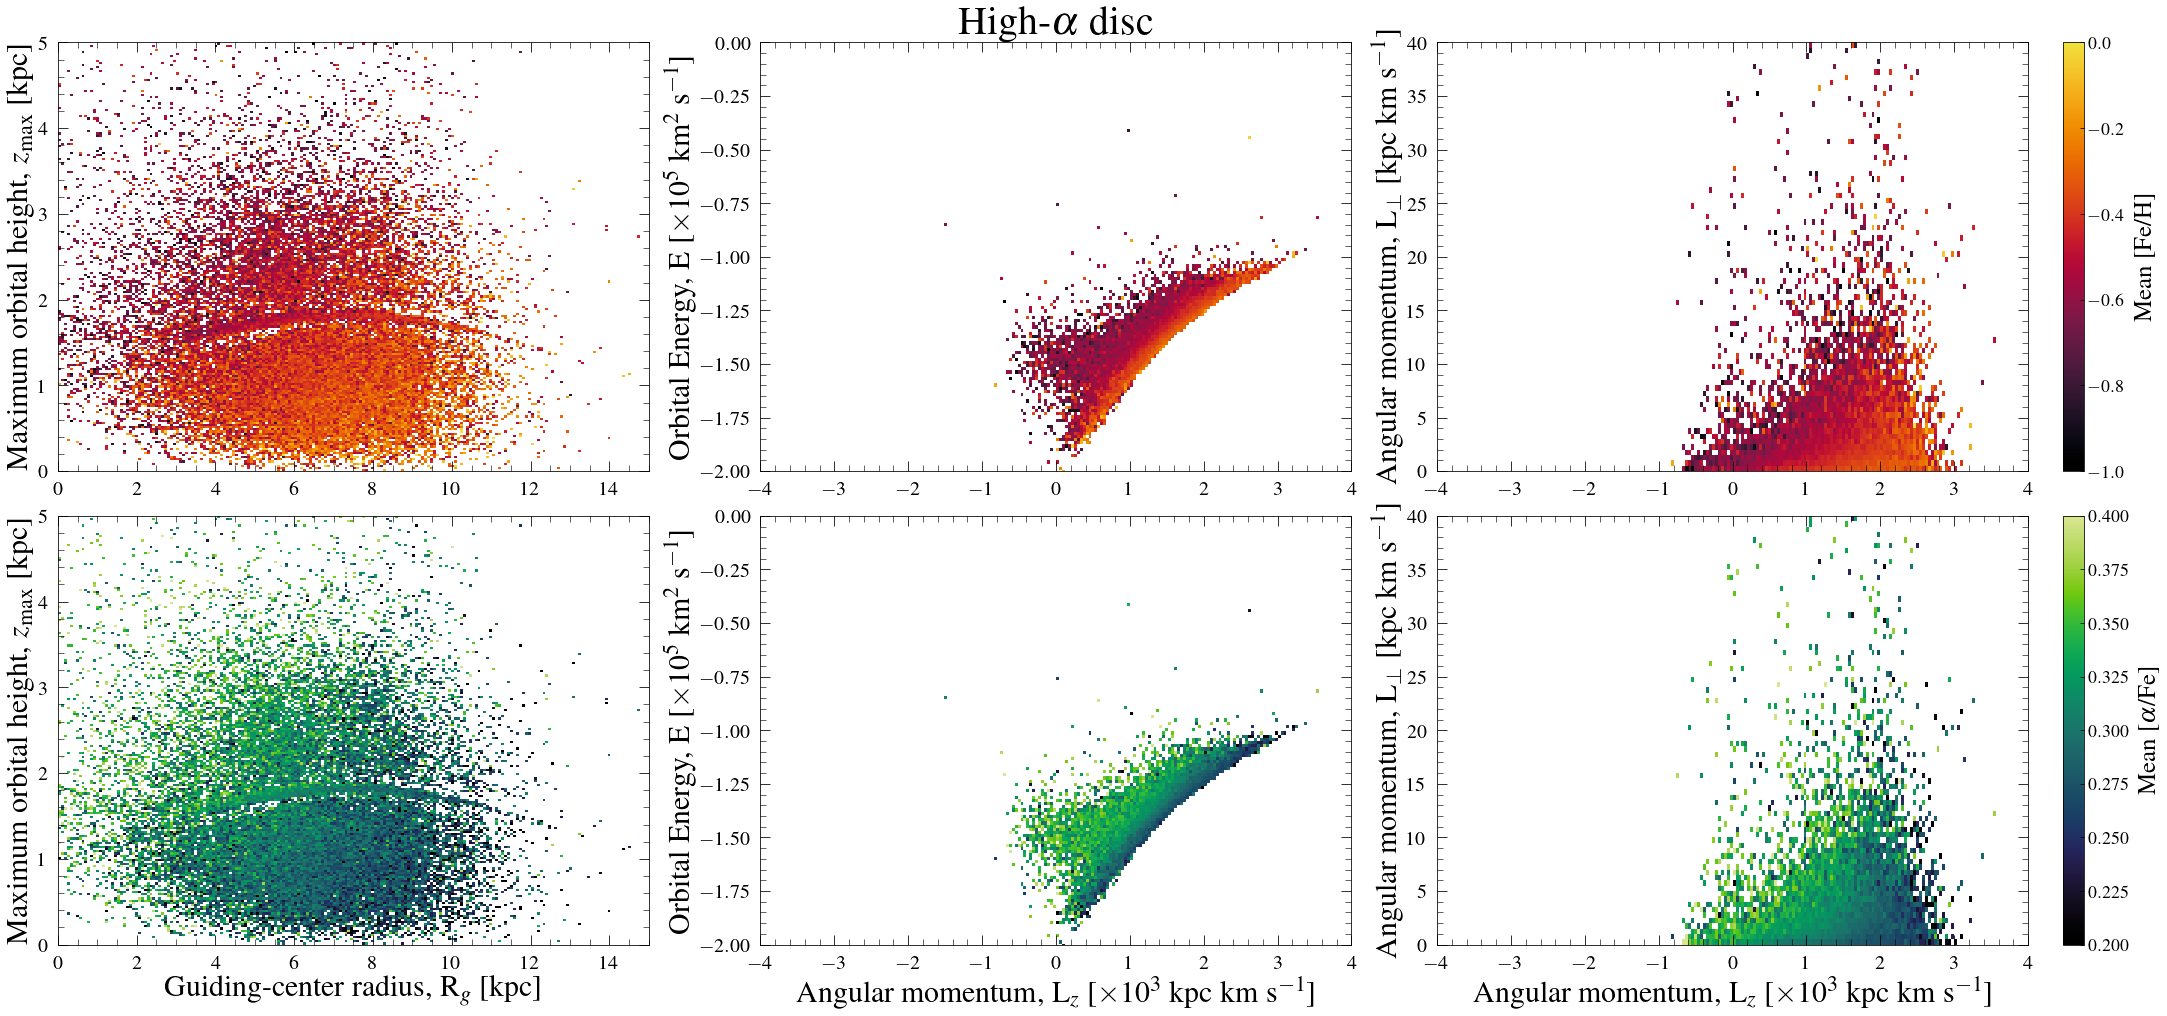

In [47]:
nbins=201
fig = plt.figure(figsize=(30,14),facecolor='white',constrained_layout=True,rasterized=True)

# fig.suptitle(r'Element abundance gradients of the Milky Way disc in orbit space', fontsize=50, y = 1.1)

plt.subplot(2,3,1)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot&higha],zmax[mask&mask_plot&higha], data['FE_H'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,2)
plt.title(r'High-$\alpha$ disc', fontsize=40)

mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&higha]/1e3,E[mask&mask_plot&higha]/1e5, data['FE_H'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&higha]/1e3,lperp[mask&mask_plot&higha], data['FE_H'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [Fe/H]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')




plt.subplot(2,3,4)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot&higha],zmax[mask&mask_plot&higha], data['MG_FE'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
plt.xlabel(r'Guiding-center radius, R$_{g}$ [kpc]',fontsize=30)
plt.ylabel(r'Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,5)
mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&higha]/1e3,E[mask&mask_plot&higha]/1e5, data['MG_FE'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&higha]/1e3,lperp[mask&mask_plot&higha], data['MG_FE'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [$\alpha$/Fe]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-abundance-maps-all-higha.pdf',dpi=200, bbox_inches = 'tight')



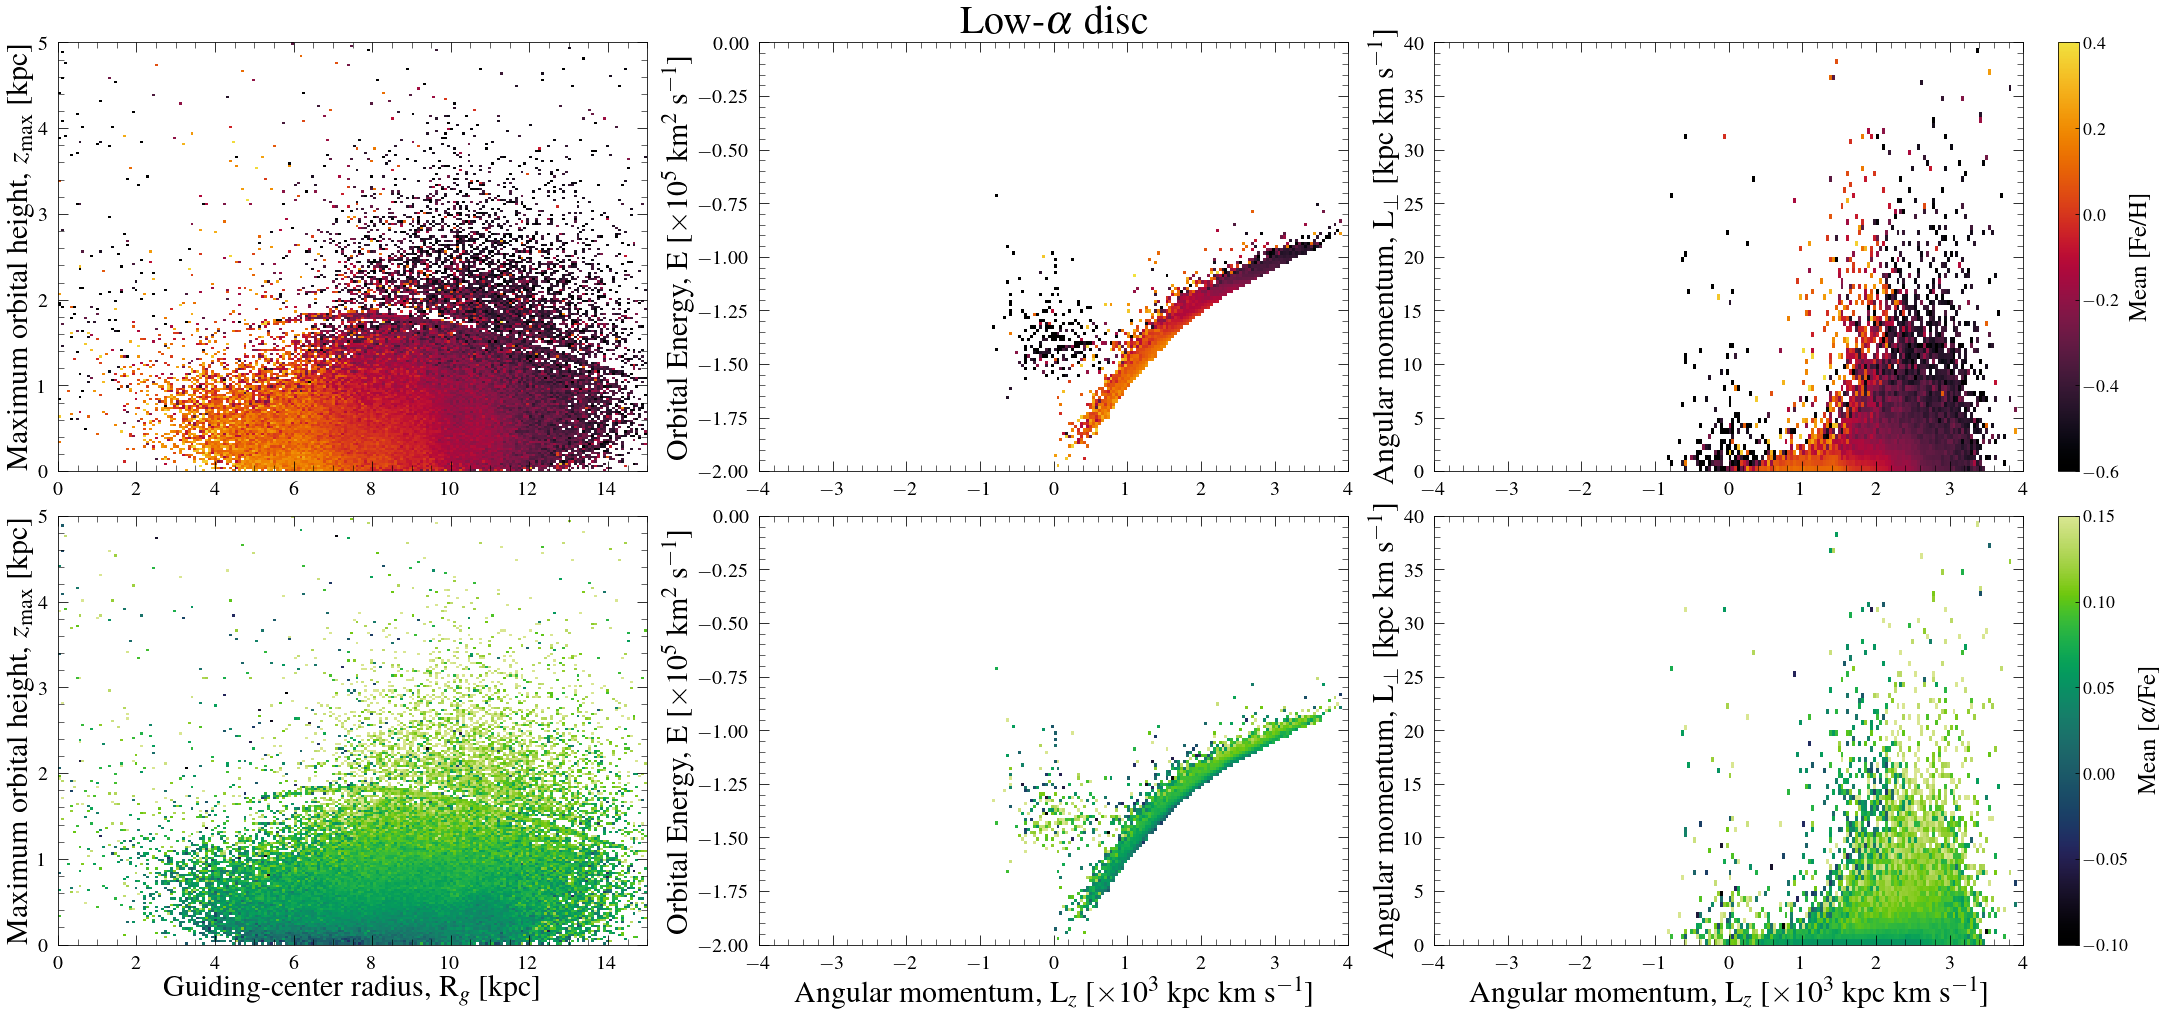

In [46]:
nbins=201
fig = plt.figure(figsize=(30,14),facecolor='white',constrained_layout=True,rasterized=True)

# fig.suptitle(r'Element abundance gradients of the Milky Way disc in orbit space', fontsize=50, y = 1.1)

plt.subplot(2,3,1)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot&lowa],zmax[mask&mask_plot&lowa], data['FE_H'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.6,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,2)
plt.title(r'Low-$\alpha$ disc', fontsize=40)

mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&lowa]/1e3,E[mask&mask_plot&lowa]/1e5, data['FE_H'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.6,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&lowa]/1e3,lperp[mask&mask_plot&lowa], data['FE_H'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.6,vmax=0.4)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [Fe/H]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')




plt.subplot(2,3,4)
mask_plot = (np.abs(Rg)<20)&(np.abs(zmax)<20.)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(0,15,nbins)
biny = np.linspace(0,5,nbins)
hist = stats.binned_statistic_2d(Rg[mask&mask_plot&lowa],zmax[mask&mask_plot&lowa], data['MG_FE'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(0,15)
plt.ylim(0,5)
plt.xlabel(r'Guiding-center radius, R$_{g}$ [kpc]',fontsize=30)
plt.ylabel(r'Maximum orbital height, $z_{\mathrm{max}}$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,5)
mask_plot = (E<0)&(E>-3e5)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
biny = np.linspace(-3,0,nbins)
binx = np.linspace(-4,4,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&lowa]/1e3,E[mask&mask_plot&lowa]/1e5, data['MG_FE'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(-2,0)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Orbital Energy, E [$\times10^{5}$ km$^{2}$ s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
mask_plot = (lperp>0)&(lperp<100)&(np.abs(lz)<4e3)&(np.abs(data['MG_FE'])<1.)
binx = np.linspace(-4,4,nbins)
biny = np.linspace(0,100,nbins)
hist = stats.binned_statistic_2d(lz[mask&mask_plot&lowa]/1e3,lperp[mask&mask_plot&lowa], data['MG_FE'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)
# plt.text(,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-4,4)
plt.ylim(0,40)
plt.xlabel(r'Angular momentum, L$_{z}$ [$\times10^{3}$ kpc km s$^{-1}$]',fontsize=30)
plt.ylabel(r'Angular momentum, L$_{\perp}$ [kpc km s$^{-1}$]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"Mean [$\alpha$/Fe]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-abundance-maps-all-lowa.pdf',dpi=200, bbox_inches = 'tight')



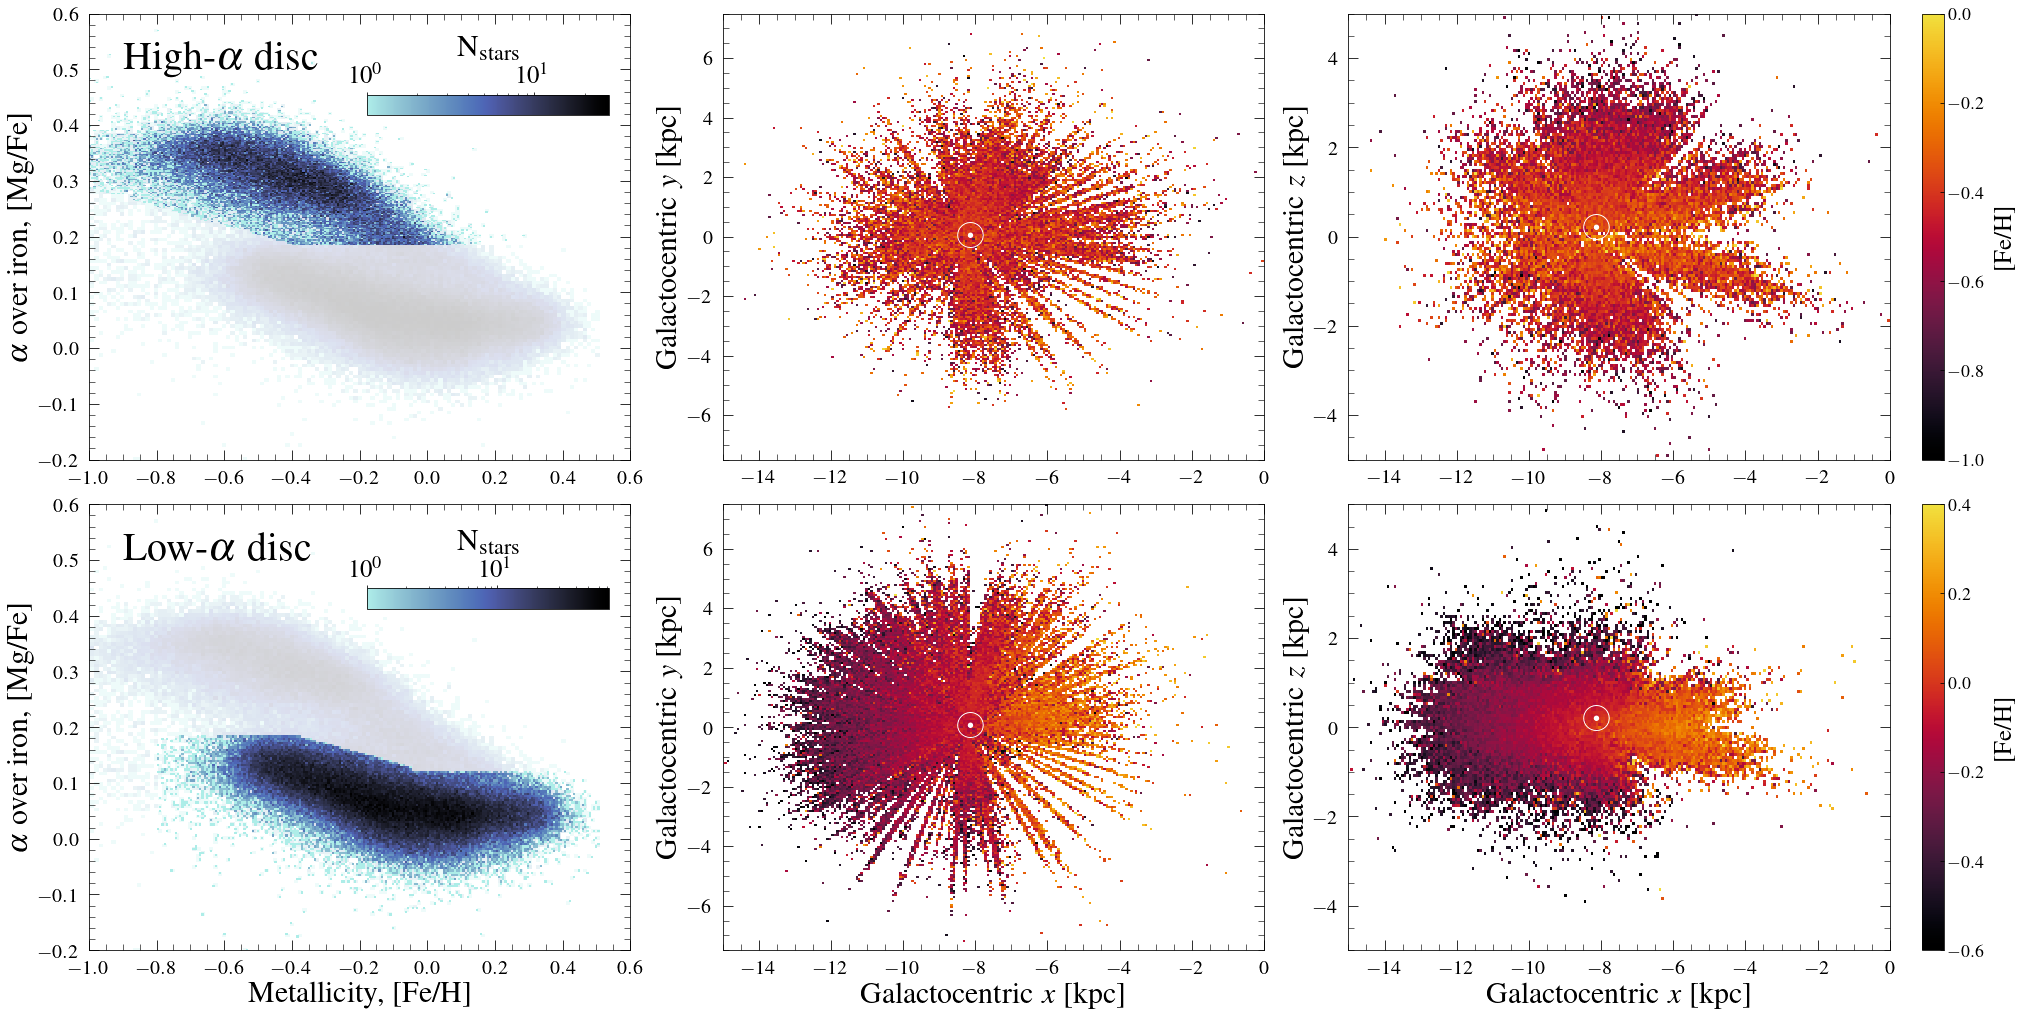

In [192]:
nbins=298
fig = plt.figure(figsize=(28,14),facecolor='white',constrained_layout=True,rasterized=True)

plt.subplot(2,3,1)
mask_plot = (np.abs(data['FE_H'])<2)&(np.abs(data['MG_FE'])<1.)
plt.hist2d(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2)
plt.text(-0.9,0.5,r'High-$\alpha$ disc',fontsize=40)
color = plt.hist2d(data['FE_H'][mask&mask_plot&higha],data['MG_FE'][mask&mask_plot&higha],bins=200,cmap=cm.sapphire_r,norm=LogNorm())
plt.xlim(-1,0.6)
plt.ylim(-0.2,0.6)
# plt.xlabel(r'Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.18, 0.89, 0.12,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,2)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,1])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&higha],data['xyz'][:,1][mask&mask_plot&higha], data['FE_H'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.)
plt.text(-8.5,-0.25,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-7.5,7.5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([0.52, 0.89, 0.12,0.02])
# cb = plt.colorbar(color,cax = cbar_ax,orientation='horizontal')
# cb.set_label(label=r"Mean [Fe/H]",fontsize=30,labelpad=10)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,3)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,2])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&higha],data['xyz'][:,2][mask&mask_plot&higha], data['FE_H'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.)
plt.text(-8.5,0.,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-5,5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $z$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"[Fe/H]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,4)
mask_plot = (np.abs(data['FE_H'])<2)&(np.abs(data['MG_FE'])<1.)
plt.hist2d(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2)
plt.text(-0.9,0.5,r'Low-$\alpha$ disc',fontsize=40)
color = plt.hist2d(data['FE_H'][mask&mask_plot&lowa],data['MG_FE'][mask&mask_plot&lowa],bins=200,cmap=cm.sapphire_r,norm=LogNorm())
plt.xlim(-1,0.6)
plt.ylim(-0.2,0.6)
plt.xlabel(r'Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.18, 0.4, 0.12,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,5)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,1])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&lowa],data['xyz'][:,1][mask&mask_plot&lowa], data['FE_H'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.6,vmax=0.4)
plt.text(-8.5,-0.25,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-7.5,7.5)
plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,2])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&lowa],data['xyz'][:,2][mask&mask_plot&lowa], data['FE_H'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.6,vmax=0.4)
plt.text(-8.5,0.,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-5,5)
plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $z$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"[Fe/H]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/data-high-low-alpha-xyz.pdf',dpi=200, bbox_inches = 'tight')



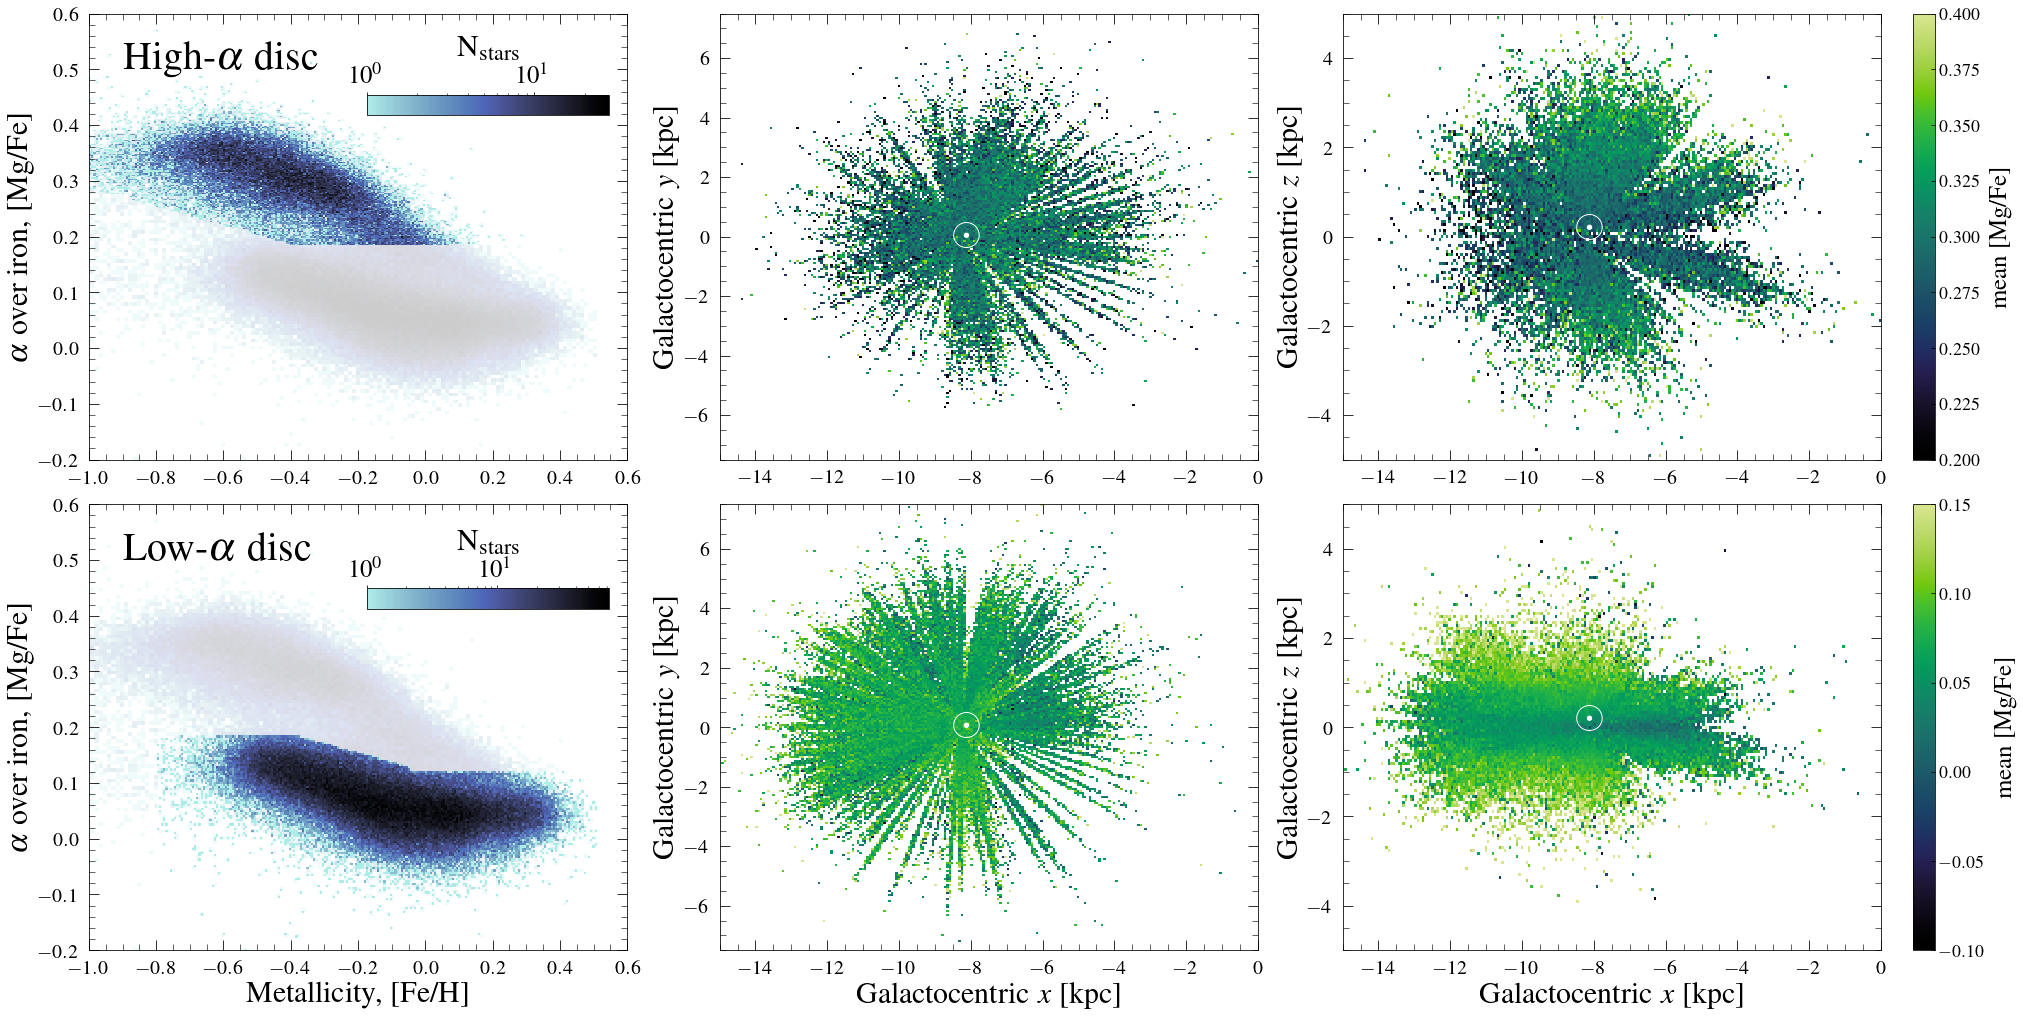

In [200]:
nbins=298
fig = plt.figure(figsize=(28,14),facecolor='white',constrained_layout=True,rasterized=True)

plt.subplot(2,3,1)
mask_plot = (np.abs(data['FE_H'])<2)&(np.abs(data['MG_FE'])<1.)
plt.hist2d(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2)
plt.text(-0.9,0.5,r'High-$\alpha$ disc',fontsize=40)
color = plt.hist2d(data['FE_H'][mask&mask_plot&higha],data['MG_FE'][mask&mask_plot&higha],bins=200,cmap=cm.sapphire_r,norm=LogNorm())
plt.xlim(-1,0.6)
plt.ylim(-0.2,0.6)
# plt.xlabel(r'Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.18, 0.89, 0.12,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,2)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,1])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&higha],data['xyz'][:,1][mask&mask_plot&higha], data['MG_FE'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)
plt.text(-8.5,-0.25,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-7.5,7.5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([0.52, 0.89, 0.12,0.02])
# cb = plt.colorbar(color,cax = cbar_ax,orientation='horizontal')
# cb.set_label(label=r"Mean [Fe/H]",fontsize=30,labelpad=10)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,3)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,2])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&higha],data['xyz'][:,2][mask&mask_plot&higha], data['MG_FE'][mask&mask_plot&higha], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)
plt.text(-8.5,0.,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-5,5)
# plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $z$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"mean [Mg/Fe]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,4)
mask_plot = (np.abs(data['FE_H'])<2)&(np.abs(data['MG_FE'])<1.)
plt.hist2d(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2)
plt.text(-0.9,0.5,r'Low-$\alpha$ disc',fontsize=40)
color = plt.hist2d(data['FE_H'][mask&mask_plot&lowa],data['MG_FE'][mask&mask_plot&lowa],bins=200,cmap=cm.sapphire_r,norm=LogNorm())
plt.xlim(-1,0.6)
plt.ylim(-0.2,0.6)
plt.xlabel(r'Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.18, 0.4, 0.12,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,3,5)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,1])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&lowa],data['xyz'][:,1][mask&mask_plot&lowa], data['MG_FE'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)
plt.text(-8.5,-0.25,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-7.5,7.5)
plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
mask_plot = (np.abs(data['xyz'][:,0])<20)&(np.abs(data['xyz'][:,2])<20.)&(np.abs(data['FE_H'])<2.)
binx = np.linspace(-20,0,nbins)
biny = np.linspace(-10,10,nbins)
hist = stats.binned_statistic_2d(data['xyz'][:,0][mask&mask_plot&lowa],data['xyz'][:,2][mask&mask_plot&lowa], data['MG_FE'][mask&mask_plot&lowa], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)
plt.text(-8.5,0.,r'$\odot$',fontsize=40,color='white',font='bold')
plt.xlim(-15,0)
plt.ylim(-5,5)
plt.xlabel('Galactocentric $x$ [kpc]',fontsize=30)
plt.ylabel('Galactocentric $z$ [kpc]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cb = fig.colorbar(color, orientation="vertical", location="right")
cb.set_label(r"mean [Mg/Fe]", fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=18,direction='in',length=4)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/data-high-low-alpha-xyz-mgfe.pdf',dpi=200, bbox_inches = 'tight')

